In [1]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json

In [2]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')

In [3]:
hgg = ak.from_parquet('/scratch365/cmoore24/training/data/ecfs/nanless_hgg.parquet')

In [4]:
qcd = ak.firsts(ak.from_parquet('/scratch365/cmoore24/training/data/ecfs/q476_ecfs.parquet'))

In [5]:
#qcd = ak.from_parquet('/scratch365/cmoore24/training/data/ecfs/nanless_qcd.parquet')

In [6]:
hgg = hgg[hgg.msoftdrop <= 170]
hgg = hgg[hgg.msoftdrop >= 80]
hgg = hgg[hgg.pt <= 600]
hgg = hgg[hgg.pt >= 450]

In [7]:
qcd = qcd[qcd.msoftdrop <= 170]
qcd = qcd[qcd.msoftdrop >= 80]
qcd = qcd[qcd.pt <= 600]
qcd = qcd[qcd.pt >= 450]

In [8]:
# mask = ak.ones_like(hgg[hgg.fields[0]], dtype='bool')
# mask = ak.fill_none(mask, True)
# for j in hgg.fields:
#     if hgg[j].fields == []:
#         mask = mask & (~ak.is_none(ak.nan_to_none(hgg[j])))
#     else:
#         for i in hgg[j].fields:
#             mask = mask & (~ak.is_none(ak.nan_to_none(hgg[j][i])))
# hgg = hgg[mask]

In [9]:
def nan_remover(sample):
    if type(sample) == dict:
        for j in sample:
            mask = ak.ones_like(sample[j][sample[j].fields[0]], dtype='bool')
            mask = ak.fill_none(mask, True)
            for k in sample[j].fields:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
            sample[j] = sample[j][mask]
    else:
        mask = ak.ones_like(sample[sample.fields[0]], dtype='bool')
        mask = ak.fill_none(mask, True)
        for j in sample.fields:
            if sample[j].fields == []:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j])))
            else:
                for k in sample[j].fields:
                    mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
        sample = sample[mask]
    return sample

In [10]:
hgg = nan_remover(hgg)

In [11]:
qcd = nan_remover(qcd)

In [12]:
with open('/scratch365/cmoore24/training/hgg/binary/ecfs_project/combo_training/outputs/trained_ratios.pkl', 'rb') as f:
    items = pickle.load(f)

In [13]:
len(items)

120

In [14]:
def add_ratio(ratio, dataframe):
    dash = ratio.find('/')
    asterisk = ratio.find('*')
    numerator = ratio[:dash]
    denominator = ratio[dash+1:asterisk]
    exponent = float(ratio[asterisk+2:])
    num_ecf = dataframe[numerator]
    den_ecf = dataframe[denominator]
    ecf_ratio = (num_ecf)/(den_ecf**exponent)
    return ecf_ratio

In [15]:
hgg_ratios = {}
for i in items:
    hgg_ratios[i] = add_ratio(i, hgg.ECFs)

In [16]:
qcd_ratios = {}
for i in items:
    qcd_ratios[i] = add_ratio(i, qcd.ECFs)

In [17]:
#items = ['Color_Ring'] + items

In [18]:
hgg_train = ak.zip({
    'Color_Ring': hgg.Color_Ring,
    'ECFs': hgg.ECFs,
    'msoftdrop': hgg.msoftdrop,
    'pt': hgg.pt,
    'ratios': ak.Array(hgg_ratios),
},
       depth_limit=1
      )

In [19]:
qcd_train = ak.zip({
    'Color_Ring': qcd.Color_Ring,
    'ECFs': qcd.ECFs,
    'msoftdrop': qcd.msoftdrop,
    'pt': qcd.pt,
    'ratios': ak.Array(qcd_ratios),
},
       depth_limit=1
      )

In [161]:
model = f'/scratch365/cmoore24/training/hgg/binary/ecfs_project/combo_training/outputs/traced_model.pt'

In [162]:
scaler = f'/scratch365/cmoore24/training/hgg/binary/ecfs_project/combo_training/outputs/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

In [163]:
def imapper(array, ratio_list):
    imap = {}
    imap['vars'] = {}
    for i in ratio_list:
        try:
            imap['vars'][i] = array.ratios[i]
        except:
            imap['vars'][i] = array[i]
    return imap

In [164]:
class EnergyCorrelatorFunctionTagger(torch_wrapper):
    def prepare_awkward(self, events, scaler, imap):
        fatjets = events

        retmap = {
            k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }
        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [165]:
tagger = EnergyCorrelatorFunctionTagger(model)

In [166]:
hgg_imap = imapper(hgg_train, items)
hgg_scores = tagger(hgg_train, scaler, hgg_imap)[:,0]

In [167]:
qcd_imap = imapper(qcd_train, items)
qcd_scores = tagger(qcd_train, scaler, qcd_imap)[:,0]

In [168]:
up = max(ak.max(hgg_scores), ak.max(qcd_scores))
up

56.193695

In [169]:
down = min(ak.min(hgg_scores), ak.min(qcd_scores))
down

-8173.8335

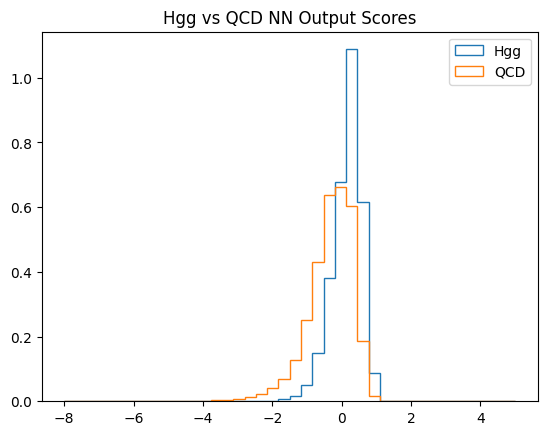

In [174]:
# pltrange = (down, up)
pltrange = (-8, 5)
plt.hist(hgg_scores, bins=40, histtype='step', label='Hgg', density=True, range=pltrange)
plt.hist(qcd_scores, bins=40, histtype='step', label='QCD', density=True, range=pltrange)
plt.title(f'Hgg vs QCD NN Output Scores')
plt.legend()
plt.show()

In [175]:
mask = ~np.isnan(qcd_scores)
qcd_scores = qcd_scores[mask]# & (qcd_scores > -6) & (qcd_scores < 6)]
qcd_train = qcd_train[mask]

In [176]:
mask = ~np.isnan(hgg_scores)
hgg_scores = hgg_scores[mask]# & (hgg_scores > -6) & (hgg_scores < 6)]
hgg_train = hgg_train[mask]

In [177]:
bkg_zeros = ak.zeros_like(qcd_scores)
sig_ones = ak.ones_like(hgg_scores)
combined = ak.concatenate([qcd_scores,hgg_scores])
combined_truth = ak.concatenate([bkg_zeros, sig_ones])

In [178]:
fpr, tpr, thresholds = roc_curve(combined_truth, combined)
roc_auc = auc(fpr, tpr)

In [179]:
hrange=(np.floor(ak.min(hgg_scores)), np.ceil(ak.max(hgg_scores)))
hrange

(-3.0, 2.0)

In [180]:
hrange=(np.floor(ak.min(qcd_scores)), np.ceil(ak.max(qcd_scores)))
hrange

(-8174.0, 57.0)

In [181]:
hrange = (-5, 3)

In [182]:
hgg_hist = np.histogram(hgg_scores, bins=20,
                range=hrange
                )
qcd_hist = np.histogram(qcd_scores, bins=20, 
                 range=hrange
                )

In [183]:
sig_sums = []
for i in range(len(hgg_hist[0])+1):
    sig_sums.append(sum(hgg_hist[0][len(hgg_hist[0])-i:]))

bkg_sums = []
for i in range(len(qcd_hist[0])+1):
    bkg_sums.append(sum(qcd_hist[0][len(qcd_hist[0])-i:]))

In [184]:
sig_ratios = []
for i in sig_sums:
    sig_ratios.append(i/sig_sums[-1])
bkg_ratios = []
for i in bkg_sums:
    bkg_ratios.append(i/bkg_sums[-1])

In [185]:
wp_ratios = {}
for i in range(len(hgg_hist[1])):
    wp_ratios[str(hgg_hist[1][-i-1])] = [sig_ratios[i], bkg_ratios[i]]

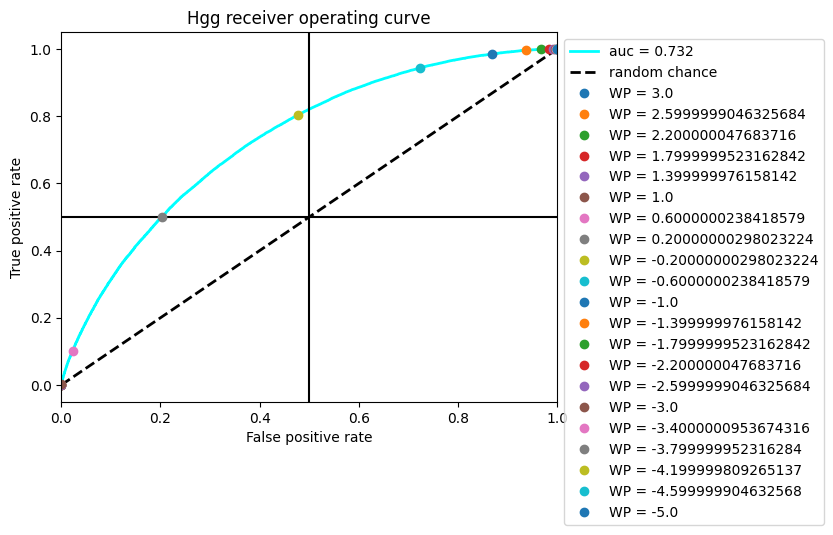

In [186]:
plt.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
plt.xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"Hgg receiver operating curve")
plt.legend(loc="lower right")
plt.axvline(x=0.5, color='black')
plt.axhline(y=0.5, color='black')
for i in wp_ratios:
    plt.plot(wp_ratios[i][1], wp_ratios[i][0], 'o', label=f'WP = {str(i)}')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [187]:
def get_cut(qcd_scores, break_val):
    hrange=(ak.min(qcd_scores), ak.max(qcd_scores))
    proportion=1.0
    i = 0
    while proportion > 0.15:
        qcd_hist = np.histogram(qcd_scores, bins=1000, 
                     range=hrange
                    )
        largest_bin_indices = np.argsort(qcd_hist[0])[-10:]
        largest_bin_vals = qcd_hist[1][largest_bin_indices]
        hrange = (largest_bin_vals[0], ak.max(qcd_scores))
        proportion = sum(qcd_hist[0])/len(qcd_scores)
        print(proportion)
        i += 1
        if i > break_val:
            break
    cumulative_distribution = np.cumsum(qcd_hist[0][min(largest_bin_indices):max(largest_bin_indices)])
    total_count = cumulative_distribution[-1]
    half_count = total_count / 2
    median_bin_index = np.where(cumulative_distribution >= half_count)[0][0]
    cut = qcd_hist[1][median_bin_index]
    return cut

In [189]:
# cut = get_cut(qcd_scores, 100)
# cut
cut = 0.2

In [190]:
mask = ~((qcd_scores > cut))
qcd_cut_msd = qcd_train.msoftdrop[mask]
qcd_fail_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='QCD MSD').Weight()
qcd_fail_hist.fill(msd=qcd_cut_msd);

In [191]:
mask = ((qcd_scores > cut))
qcd_cut_msd = qcd_train.msoftdrop[mask]
qcd_pass_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='QCD MSD').Weight()
qcd_pass_hist.fill(msd=qcd_cut_msd);

In [192]:
with open('../../jsons/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
with open('../../jsons/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [193]:
scale = ((44.99*(xsecs['qcd']['qcd_470to600']*1000))/totals['qcd']['470to600'])
qcd_pass_hist.view(flow=True)[:] *= scale
qcd_fail_hist.view(flow=True)[:] *= scale

In [194]:
total_qcd_hist = qcd_pass_hist + qcd_fail_hist

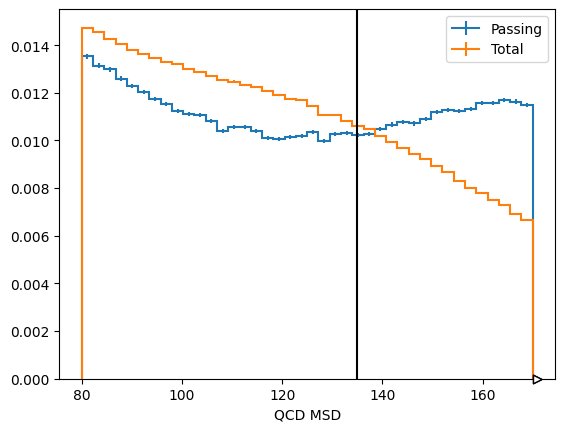

In [195]:
qcd_pass_hist.plot1d(density=True, label='Passing')
#qcd_fail_hist.plot1d(density=True, label='Failing')
total_qcd_hist.plot1d(density=True, label='Total')
plt.axvline(135, color='black')
plt.legend()
plt.show()

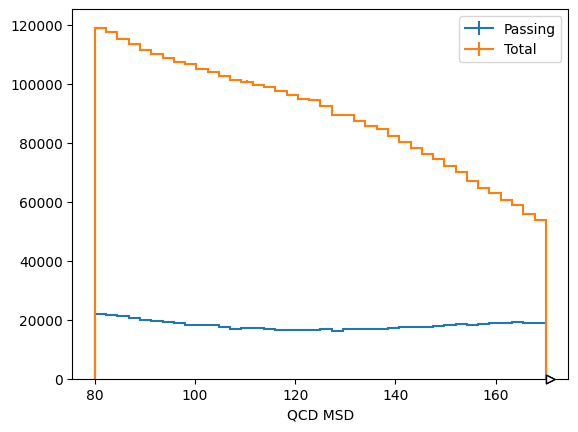

In [196]:
qcd_pass_hist.plot1d(density=False, label='Passing')
#qcd_fail_hist.plot1d(density=True, label='Failing')
total_qcd_hist.plot1d(density=False, label='Total')
plt.legend()
plt.show()

In [197]:
sum(qcd_pass_hist.values()), sum(total_qcd_hist.values())

(726691.9304001885, 3593507.2354559423)

In [198]:
sum(qcd_pass_hist.values())/sum(total_qcd_hist.values())

0.20222358904141352

In [199]:
sculpt_metric = sum(abs(total_qcd_hist.density() - qcd_pass_hist.density()))

In [200]:
sculpt_metric

0.07618015449159107

In [201]:
mask = ~((hgg_scores > cut))
hgg_cut_msd = hgg_train.msoftdrop[mask]
hgg_fail_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='Hgg MSD').Weight()
hgg_fail_hist.fill(msd=hgg_cut_msd);

In [202]:
mask = ((hgg_scores > cut))
hgg_cut_msd = hgg_train.msoftdrop[mask]
hgg_pass_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='Hgg MSD').Weight()
hgg_pass_hist.fill(msd=hgg_cut_msd);

In [203]:
scaleHgg = ((44.99*(xsecs['hgg']*1000)*0.0817)/(totals['hgg']))
hgg_fail_hist.view(flow=True)[:] *= scaleHgg
hgg_pass_hist.view(flow=True)[:] *= scaleHgg

In [204]:
total_hgg_hist = hgg_pass_hist + hgg_fail_hist

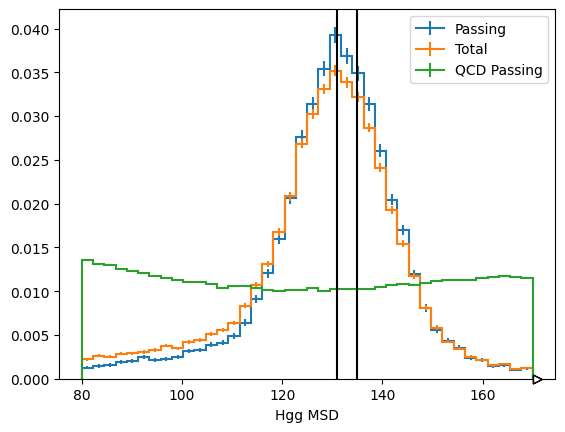

In [205]:
hgg_pass_hist.plot1d(density=True, label='Passing')
#qcd_fail_hist.plot1d(density=True, label='Failing')
total_hgg_hist.plot1d(density=True, label='Total')
qcd_pass_hist.plot1d(density=True, label='QCD Passing')
plt.axvline(135, color='black')
plt.axvline(131, color='black')
plt.legend()
plt.show()

In [206]:
sum(hgg_pass_hist.values()), sum(total_hgg_hist.values())

(15.496294551017753, 30.986076229570795)